In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Your task is to interpret this data set using the Random Forest method by sampling the data set first and plotting the result as you increase the number of samples. Plot how the predictor variables change as you grow the sampling.

This is the dataset used in the second chapter of Aurélien Géron's recent book, 'Hands-On Machine learning with Scikit-Learn and TensorFlow.' It serves as an excellent introduction to implementing machine learning algorithms because
it requires rudimentary data cleaning, has an easily understandable list of variables, and is optimally sized between being too toyish and too cumbersome.

The data contains information from the 1990 California census. So, although it may not help you predict current housing prices like the Zillow Zestimate dataset, it provides an accessible introductory dataset for teaching people about
the basics of machine learning.  The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned: (1) the data aren't cleaned so there are some preprocessing
steps required! and (2) Relatively large sample (20640 samples with 8 features) and can take sometime to run Shapley that is based on factorial permutations!

In [3]:
df.shape

(20640, 10)

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

In [6]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
class FeatureSelector:
    def get_num_cols(df):
        dtypes = df.dtypes.to_dict()
        num_cols = []
        for col, dtype in dtypes.items():
            if dtype in ['float', 'int']:
                num_cols.append(col)
        return num_cols

    def bool_to_int(df, columns = None):
        if not columns:
            columns = df.columns
        dtypes = df.dtypes.to_dict()
        for col, dtype in dtypes.items():
            if dtype == 'bool' or dtype =='boolean' and col in columns:
                df[col] = df[col].astype(int)
        return df
    
    def get_high_corr_vars(df, threshold = 0.9):
        num_cols = FeatureSelector.get_num_cols(df)
        corr_mat = df[num_cols].corr()
        mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=0)
        corr_mat = corr_mat.where(~mask)
        for col in corr_mat:
            for ind in corr_mat[corr_mat[col] >= threshold].index:
                print(f"{col} - {ind}: {corr_mat.loc[ind, col]:0.2f}")

In [8]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

ohe = ['ocean_proximity']
for col in ohe:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = X.drop(col, axis=1)
    X = pd.concat([X, dummies], axis=1)

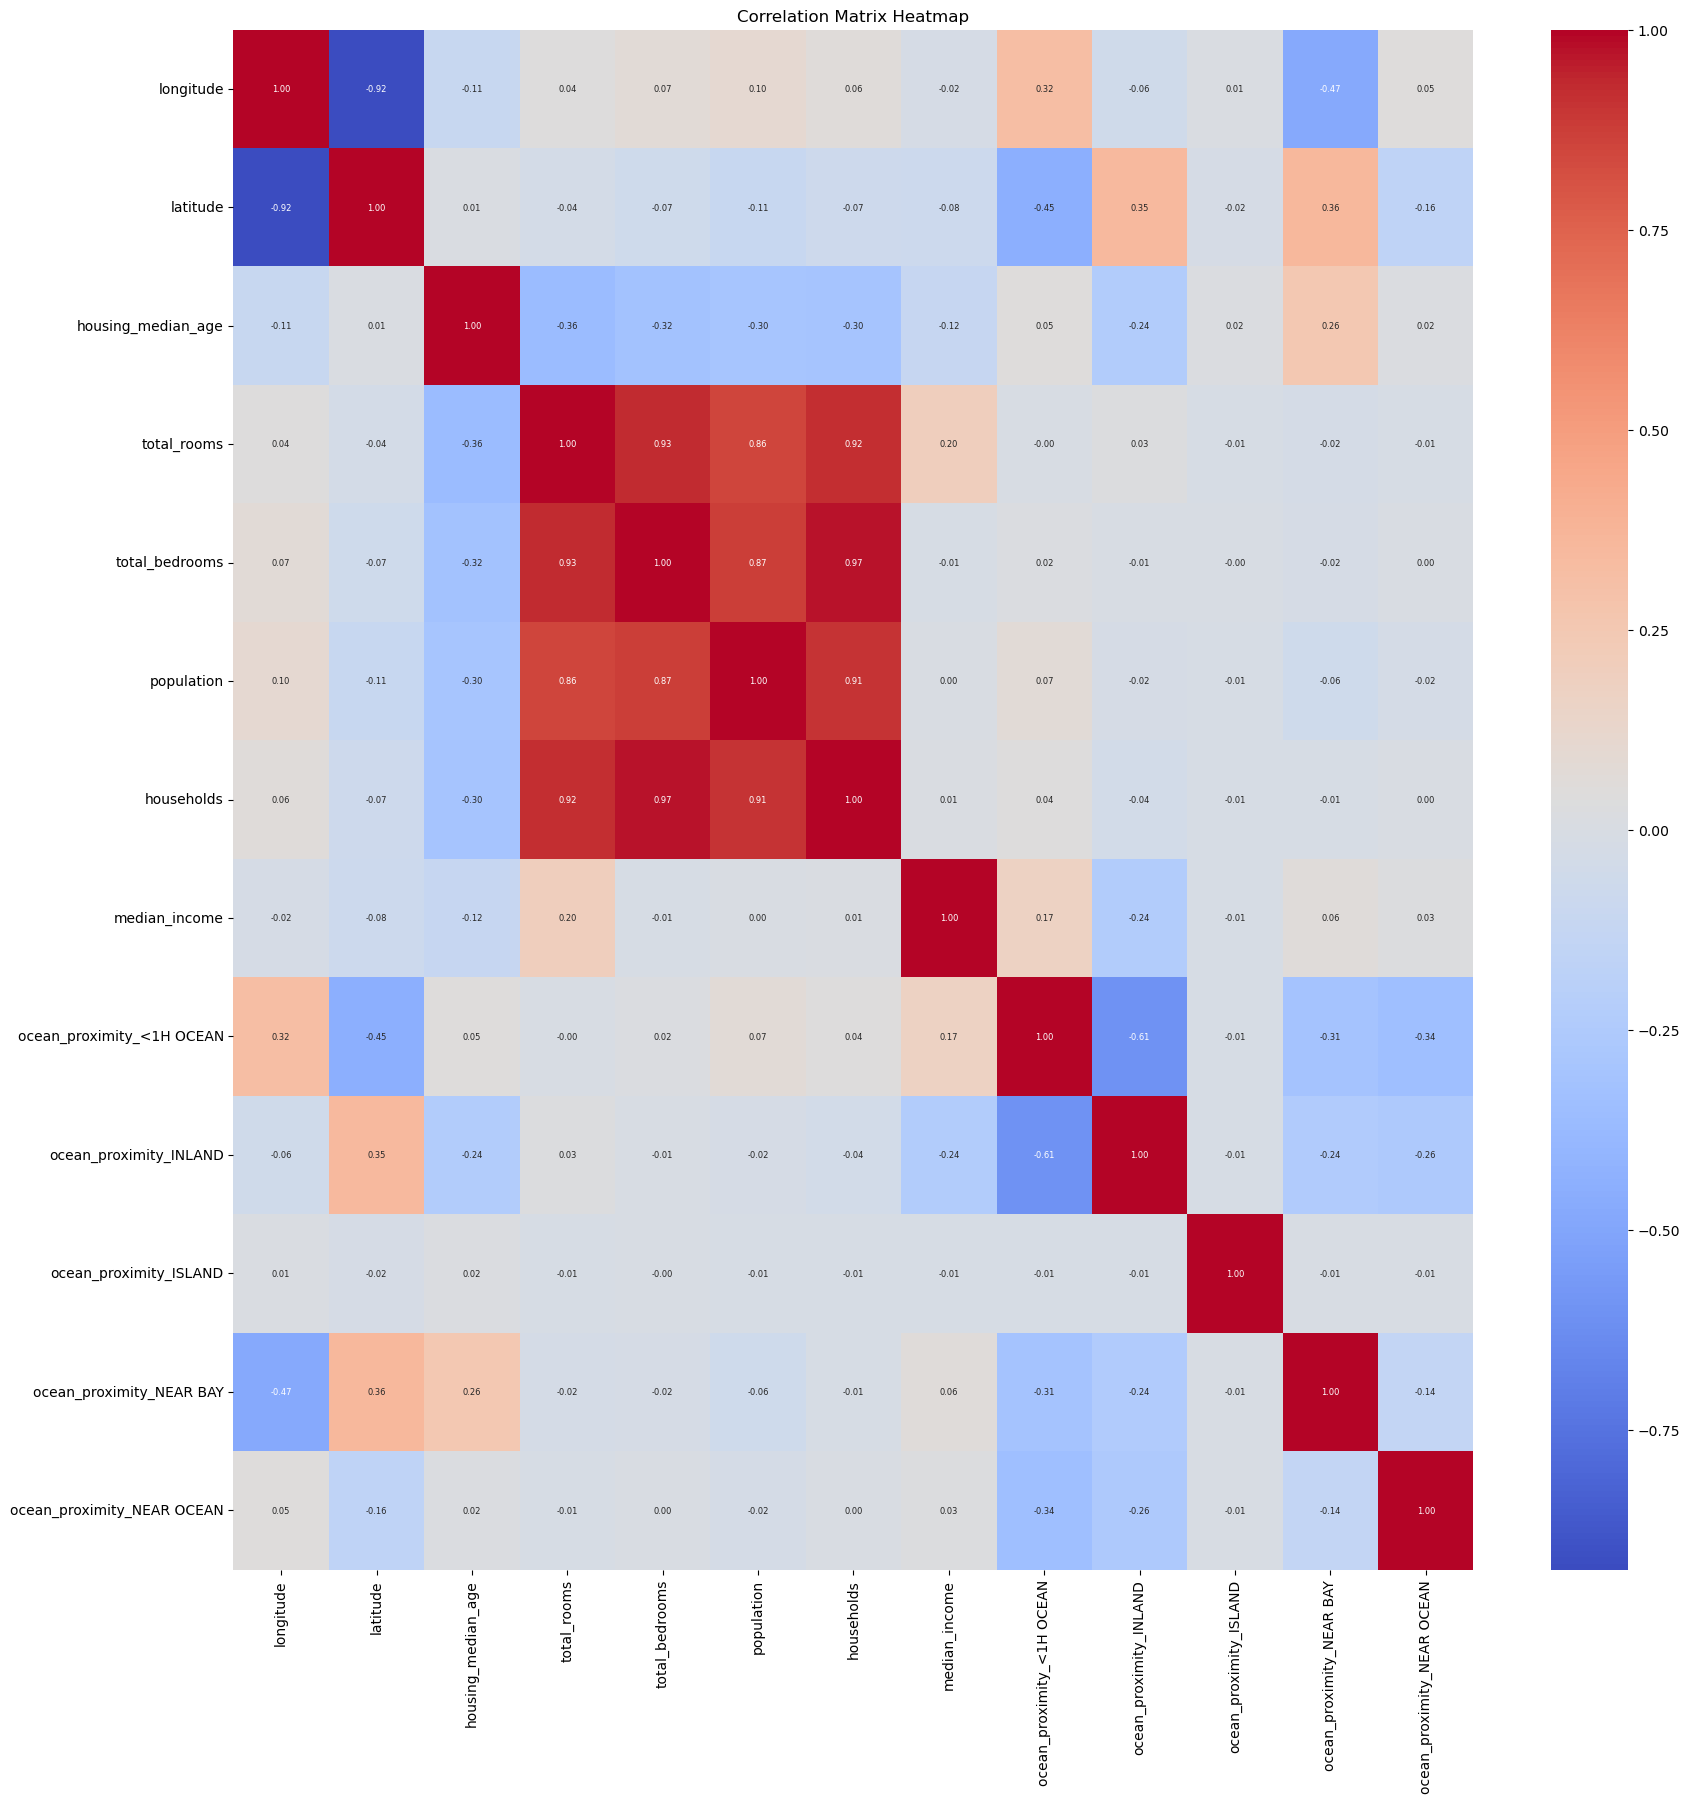

In [9]:
corr_mat = X.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

plt.title('Correlation Matrix Heatmap')
plt.show()

In [10]:
FeatureSelector.get_high_corr_vars(X)

total_rooms - total_bedrooms: 0.93
total_rooms - households: 0.92
total_bedrooms - households: 0.97
population - households: 0.91


In [11]:
X = X.drop(['total_bedrooms', 'households'], axis=1)

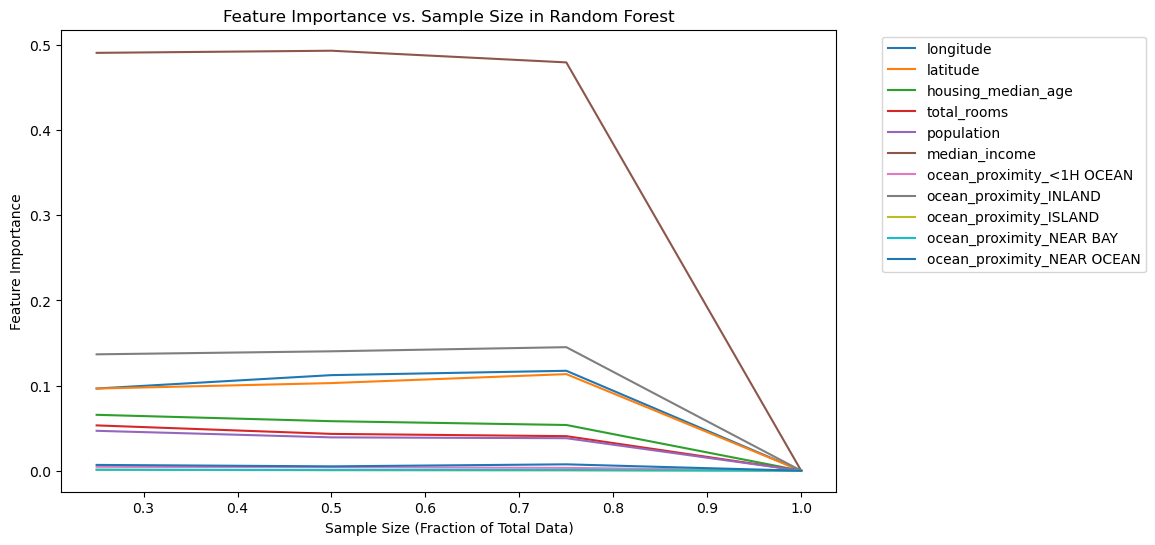

In [12]:
sample_sizes = [.25, .5, .75, 1]
feature_importances = []


for sample_size in sample_sizes:
    X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size)
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_sample, y_sample)
    
    feature_importances.append(rf_model.feature_importances_)


feature_importances_df = pd.DataFrame(feature_importances, columns=X.columns, index=sample_sizes)

plt.figure(figsize=(10, 6))
for column in feature_importances_df.columns:
    plt.plot(feature_importances_df.index, feature_importances_df[column], label=column)
    
plt.xlabel('Sample Size (Fraction of Total Data)')
plt.ylabel('Feature Importance')
plt.title('Feature Importance vs. Sample Size in Random Forest')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()